In [1]:
%load_ext autoreload
%autoreload 2

### Agent training

In [2]:
from transformers import AutoImageProcessor
import torch
from torch.utils.data import DataLoader
from stable_baselines3 import PPO
from stable_baselines3.common import env_checker

from uav_active_sensing.pytorch_datasets import TinyImageNetDataset, tiny_imagenet_collate_fn
from uav_active_sensing.modeling.img_env.img_exploration_env import RewardFunction, ImageExplorationEnv, ImageExplorationEnvConfig
from uav_active_sensing.modeling.mae.act_vit_mae import ActViTMAEForPreTraining
from uav_active_sensing.plots import visualize_tensor
from uav_active_sensing.modeling.agents.rl_agent_feature_extractor import CustomResNetFeatureExtractor

2025-02-20 19:07:17.702 | INFO     | uav_active_sensing.config:<module>:14 - PROJ_ROOT path is: /home/tcouso/uav_active_sensing
2025-02-20 19:07:17.705 | INFO     | uav_active_sensing.config:<module>:49 - Using device: cpu


In [3]:


image_processor = AutoImageProcessor.from_pretrained("facebook/vit-mae-base", use_fast=True)
tiny_imagenet_train_dataset = TinyImageNetDataset(split="train", transform=image_processor)
tiny_imagenet_train_loader = DataLoader(tiny_imagenet_train_dataset, batch_size=1, collate_fn=tiny_imagenet_collate_fn)

# Pretrained model and reward function
mae_model = ActViTMAEForPreTraining.from_pretrained("facebook/vit-mae-base")
reward_function = RewardFunction(mae_model)

# Create a dummy environment to initialize the model
dummy_batch = next(iter(tiny_imagenet_train_loader))  # Take one image as a dummy input for env initialization
env_config = ImageExplorationEnvConfig(img=dummy_batch, reward_function=reward_function)
env = ImageExplorationEnv(env_config)

In [4]:
env_checker.check_env(env)

/home/tcouso/.virtualenvs/uav_active_sensing/lib/python3.12/site-packages/stable_baselines3/common/env_checker.py:272: UserWarning: Your observation  has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(


### Batch env

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..2.64].


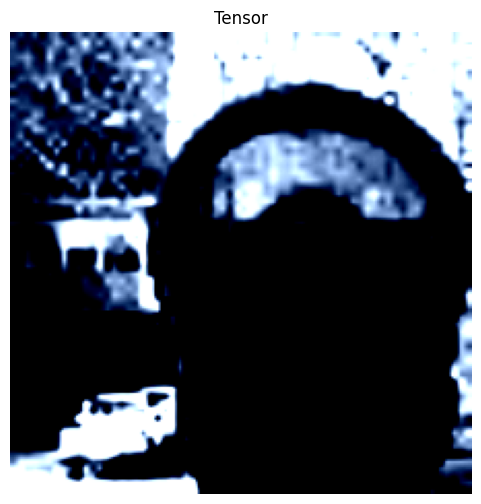

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.55469..1.5497069].


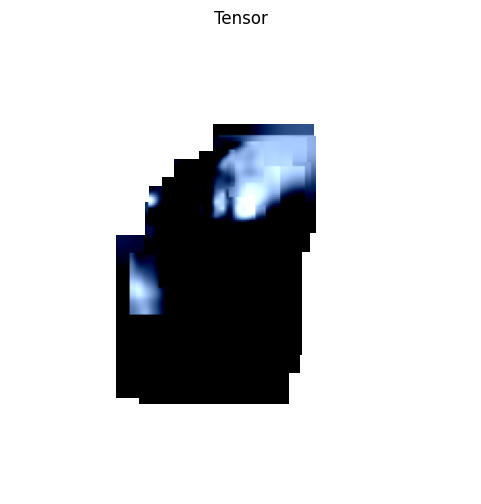

In [5]:
for _ in range(env._max_steps):
    sample_action = env.action_space.sample()
    env.step(sample_action)

for i in range(env.batch_size):
    visualize_tensor(env.img[i])
    visualize_tensor(env.sampled_img[i])

### Agent training

In [6]:
rl_num_envs = 1
rl_batch_size = 4
rl_num_steps = rl_batch_size * rl_num_envs * 4

policy_kwargs = dict(
    features_extractor_class=CustomResNetFeatureExtractor,
    features_extractor_kwargs=dict(features_dim=512),
)
env.reset()
resnet_rl_model = PPO(
    "CnnPolicy",
    env,
    policy_kwargs=policy_kwargs,
    verbose=1,
    n_steps=rl_num_steps,
    batch_size=rl_batch_size
)

for i, batch in enumerate(tiny_imagenet_train_loader):
    vec_env = resnet_rl_model.get_env()
    vec_env.env_method("set_img", batch)
    resnet_rl_model.learn(total_timesteps=4 * rl_num_steps, progress_bar=False)

    if i == 1:
        break

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------
| time/              |    |
|    fps             | 1  |
|    iterations      | 1  |
|    time_elapsed    | 12 |
|    total_timesteps | 16 |
---------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 31         |
|    ep_rew_mean          | 7.33       |
| time/                   |            |
|    fps                  | 0          |
|    iterations           | 2          |
|    time_elapsed         | 41         |
|    total_timesteps      | 32         |
| train/                  |            |
|    approx_kl            | 0.02708684 |
|    clip_fraction        | 0.119      |
|    clip_range           | 0.2        |
|    entropy_loss         | -4.26      |
|    explained_variance   | -0.000303  |
|    learning_rate        | 0.0003     |
|    loss                 | 0.0569     |
|    n_update

In [7]:
# test_env = ImageExplorationEnv(env_config)
test_env = resnet_rl_model.env.envs[0].env


# Reset environment and get initial observation
obs, _ = test_env.reset()

# Number of steps to run the evaluation
num_eval_steps = 30

# Disable training mode
resnet_rl_model.policy.eval()

for step in range(num_eval_steps):

    obs_tensor = torch.tensor(obs, dtype=torch.float32)
    action, _ = resnet_rl_model.predict(obs_tensor, deterministic=True)
    obs, reward, terminated, truncated, _ = test_env.step(action)

    # Print results
    print(f"Step {step + 1}: Action={action}, Reward={reward}")

    # if terminated or truncated:
    #     print("Episode ended, resetting environment.")
    #     obs, _ = test_env.reset()

Step 1: Action=[[ 0.13288662  0.00670513 -0.09566907]], Reward=0.5166496634483337
Step 2: Action=[[ 0.1328876   0.00659221 -0.09566233]], Reward=0.0
Step 3: Action=[[ 0.13283797  0.00651704 -0.09570022]], Reward=0.5039016604423523
Step 4: Action=[[ 0.13282458  0.00648037 -0.09567378]], Reward=0.0
Step 5: Action=[[ 0.13279168  0.00637864 -0.09571178]], Reward=0.5204890370368958
Step 6: Action=[[ 0.13280234  0.0063438  -0.0956824 ]], Reward=0.0
Step 7: Action=[[ 0.13279124  0.00632892 -0.09563697]], Reward=0.5056557655334473
Step 8: Action=[[ 0.13277602  0.00635236 -0.09556531]], Reward=0.0
Step 9: Action=[[ 0.13289362  0.0065631  -0.09530276]], Reward=0.5122984051704407
Step 10: Action=[[ 0.13301007  0.00672327 -0.09508444]], Reward=0.0
Step 11: Action=[[ 0.13321035  0.00695948 -0.09480421]], Reward=0.5332131385803223
Step 12: Action=[[ 0.13327074  0.00702268 -0.09486064]], Reward=0.0
Step 13: Action=[[ 0.13342777  0.00711183 -0.09471237]], Reward=0.5344375967979431
Step 14: Action=[[ 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2885153].


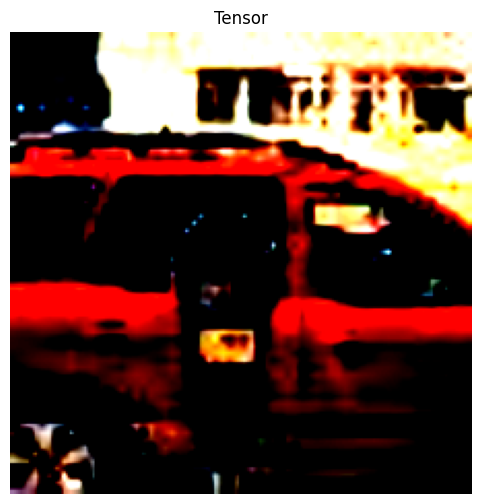

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5771098..0.90386945].


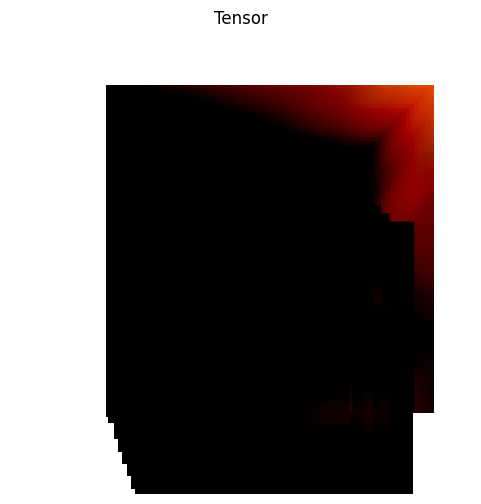

In [8]:
for i in range(test_env.batch_size):
    visualize_tensor(test_env.img[i])
    visualize_tensor(test_env.sampled_img[i])